In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Abrimos el archivo con los nombres
dataset = open('../data/domain_names_full.txt', 'r').read().splitlines()
dataset[:8]

['google.com',
 'a-msedge.net',
 'microsoft.com',
 'facebook.com',
 'amazonaws.com',
 'googleapis.com',
 'apple.com',
 'youtube.com']

In [5]:
len(dataset)

4345850

In [6]:
charset = ['*'] + sorted(list(set([y for x in dataset for y in x])))
ctoi = {c:i for i, c in enumerate(charset)}
itoc = {i:c for i, c in enumerate(charset)}
charset_len = len(charset)
print(ctoi)

{'*': 0, '-': 1, '.': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '_': 13, 'a': 14, 'b': 15, 'c': 16, 'd': 17, 'e': 18, 'f': 19, 'g': 20, 'h': 21, 'i': 22, 'j': 23, 'k': 24, 'l': 25, 'm': 26, 'n': 27, 'o': 28, 'p': 29, 'q': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'v': 35, 'w': 36, 'x': 37, 'y': 38, 'z': 39}


### Construcción del dataset
Vamos a armar un dataset como para entrenar una red neuronal, con ejemplos de entrenamiento X y etiquetas Y.

In [25]:
context_size = 3  # El tamaño del contexto o cuantos caracteres vamos a usar para predecir el siguiente
X, Y = [], []

for d in dataset[:5]:
    print(d)
    example = list(d) + ['*']
    context = [0] * context_size
    for c in example:
        print(''.join([itoc[x] for x in context]) + ' --> ' + c)
        X.append(context)
        Y.append(ctoi[c])
        context = context[1:] + [ctoi[c]]
X = torch.tensor(X)
Y = torch.tensor(Y)

google.com
*** --> g
**g --> o
*go --> o
goo --> g
oog --> l
ogl --> e
gle --> .
le. --> c
e.c --> o
.co --> m
com --> *
a-msedge.net
*** --> a
**a --> -
*a- --> m
a-m --> s
-ms --> e
mse --> d
sed --> g
edg --> e
dge --> .
ge. --> n
e.n --> e
.ne --> t
net --> *
microsoft.com
*** --> m
**m --> i
*mi --> c
mic --> r
icr --> o
cro --> s
ros --> o
oso --> f
sof --> t
oft --> .
ft. --> c
t.c --> o
.co --> m
com --> *
facebook.com
*** --> f
**f --> a
*fa --> c
fac --> e
ace --> b
ceb --> o
ebo --> o
boo --> k
ook --> .
ok. --> c
k.c --> o
.co --> m
com --> *
amazonaws.com
*** --> a
**a --> m
*am --> a
ama --> z
maz --> o
azo --> n
zon --> a
ona --> w
naw --> s
aws --> .
ws. --> c
s.c --> o
.co --> m
com --> *


In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([65, 3]), torch.int64, torch.Size([65]), torch.int64)

In [27]:
X,Y

(tensor([[ 0,  0,  0],
         [ 0,  0, 20],
         [ 0, 20, 28],
         [20, 28, 28],
         [28, 28, 20],
         [28, 20, 25],
         [20, 25, 18],
         [25, 18,  2],
         [18,  2, 16],
         [ 2, 16, 28],
         [16, 28, 26],
         [ 0,  0,  0],
         [ 0,  0, 14],
         [ 0, 14,  1],
         [14,  1, 26],
         [ 1, 26, 32],
         [26, 32, 18],
         [32, 18, 17],
         [18, 17, 20],
         [17, 20, 18],
         [20, 18,  2],
         [18,  2, 27],
         [ 2, 27, 18],
         [27, 18, 33],
         [ 0,  0,  0],
         [ 0,  0, 26],
         [ 0, 26, 22],
         [26, 22, 16],
         [22, 16, 31],
         [16, 31, 28],
         [31, 28, 32],
         [28, 32, 28],
         [32, 28, 19],
         [28, 19, 33],
         [19, 33,  2],
         [33,  2, 16],
         [ 2, 16, 28],
         [16, 28, 26],
         [ 0,  0,  0],
         [ 0,  0, 19],
         [ 0, 19, 14],
         [19, 14, 16],
         [14, 16, 18],
         [1

## La red neuronal
La red que vamos a implementar es similar a la de este paper. La principal diferencia es que vamos a implementar el modelo de lenguaje a nivel de caracteres en lugar a a nivel de palabras como en el paper. 

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

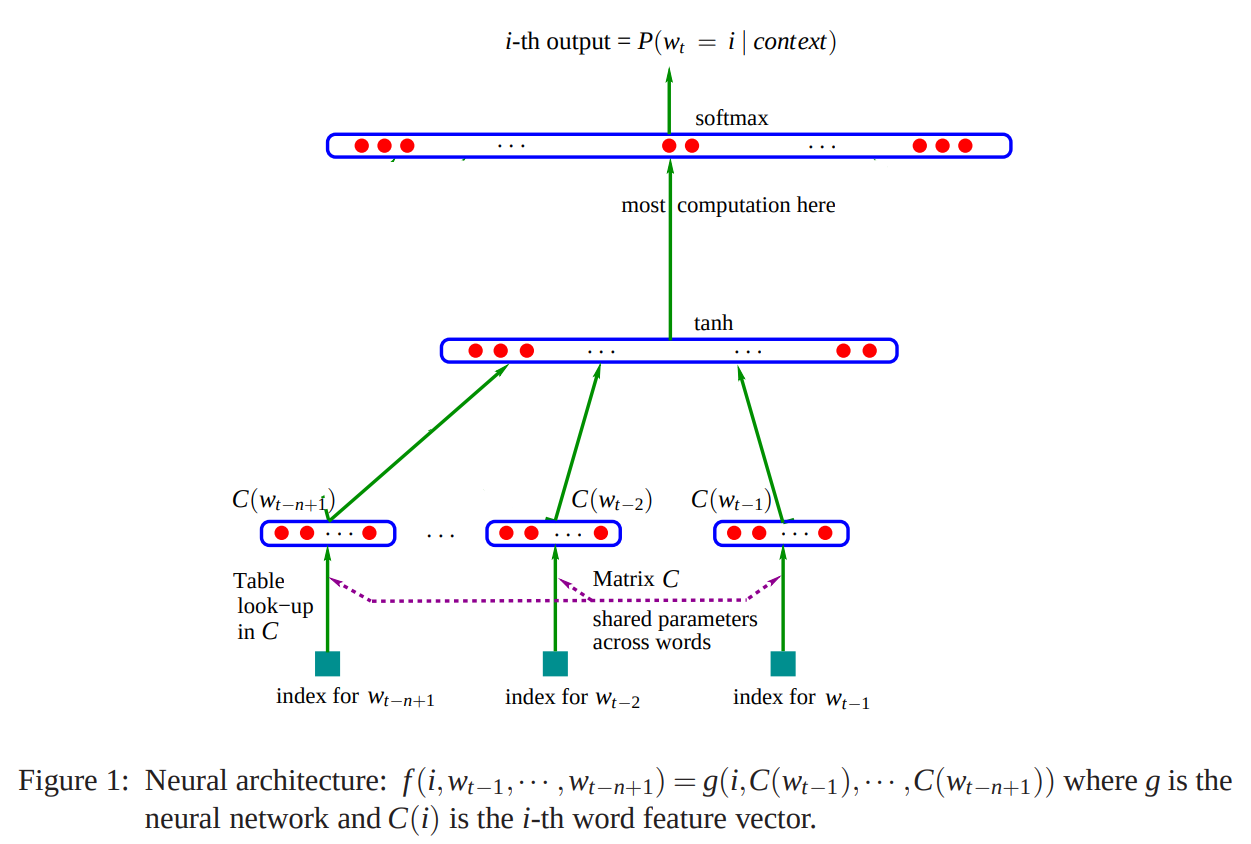

In [67]:
g = torch.Generator().manual_seed(42)
emb_d = 2  # El número de dimensiones del Enbedding
C = torch.randn(charset_len, emb_d, generator=g)
emb = C[X]

In [68]:
emb.view((65,6))

tensor([[ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -1.5576,  0.9956],
        [ 1.9269,  1.4873, -1.5576,  0.9956, -1.4032,  0.0360],
        [-1.5576,  0.9956, -1.4032,  0.0360, -1.4032,  0.0360],
        [-1.4032,  0.0360, -1.4032,  0.0360, -1.5576,  0.9956],
        [-1.4032,  0.0360, -1.5576,  0.9956,  0.0780,  0.5258],
        [-1.5576,  0.9956,  0.0780,  0.5258,  0.3189, -0.4245],
        [ 0.0780,  0.5258,  0.3189, -0.4245,  0.6784, -1.2345],
        [ 0.3189, -0.4245,  0.6784, -1.2345, -1.3847, -0.8712],
        [ 0.6784, -1.2345, -1.3847, -0.8712, -1.4032,  0.0360],
        [-1.3847, -0.8712, -1.4032,  0.0360, -0.4880,  1.1914],
        [ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -0.2316,  0.0418],
        [ 1.9269,  1.4873, -0.2316,  0.0418,  0.9007, -2.1055],
        [-0.2316,  0.0418,  0.9007, -2.1055, -0.4880,  1.1914],
        [ 0.9007, -2.1055, -0.4880,  1.1

Por que hacen falta los embeddings??

In [80]:
emb.view((65,6))# 65 muestras, context size, donde cada context se proyecta a emb_d dimensiones

tensor([[ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -1.5576,  0.9956],
        [ 1.9269,  1.4873, -1.5576,  0.9956, -1.4032,  0.0360],
        [-1.5576,  0.9956, -1.4032,  0.0360, -1.4032,  0.0360],
        [-1.4032,  0.0360, -1.4032,  0.0360, -1.5576,  0.9956],
        [-1.4032,  0.0360, -1.5576,  0.9956,  0.0780,  0.5258],
        [-1.5576,  0.9956,  0.0780,  0.5258,  0.3189, -0.4245],
        [ 0.0780,  0.5258,  0.3189, -0.4245,  0.6784, -1.2345],
        [ 0.3189, -0.4245,  0.6784, -1.2345, -1.3847, -0.8712],
        [ 0.6784, -1.2345, -1.3847, -0.8712, -1.4032,  0.0360],
        [-1.3847, -0.8712, -1.4032,  0.0360, -0.4880,  1.1914],
        [ 1.9269,  1.4873,  1.9269,  1.4873,  1.9269,  1.4873],
        [ 1.9269,  1.4873,  1.9269,  1.4873, -0.2316,  0.0418],
        [ 1.9269,  1.4873, -0.2316,  0.0418,  0.9007, -2.1055],
        [-0.2316,  0.0418,  0.9007, -2.1055, -0.4880,  1.1914],
        [ 0.9007, -2.1055, -0.4880,  1.1

In [96]:
input_size = 6  # context size * emb_d
n_hidden = 128  # El número de neuronas en al capa hiddend que queremos
W1 = torch.randn(input_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)

In [97]:
W1.shape, b1.shape

(torch.Size([6, 128]), torch.Size([128]))

In [98]:
#F.softmax(logits,dim=1)

In [99]:
emb1 = emb.view(-1,input_size)
(emb1 @ W1).shape, b1.shape

(torch.Size([65, 128]), torch.Size([128]))

In [100]:
# 65, 128
#  1, 128

In [101]:
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)

In [102]:
h.shape

torch.Size([65, 128])

In [95]:
W2 = torch.randn(n_hidden, charset_len, generator=g)
b2 = torch.randn(charset_len, generator=g)

In [103]:
logits = h @ W2 + b2

In [104]:
counts = logits.exp()
probs = counts / counts.sum(axis=1, keepdims=True)

In [105]:
loss = -probs[torch.arange(len(Y)), Y].log().mean()

In [106]:
loss

tensor(20.5318)

In [107]:
# Pasando en limpio
g = torch.Generator().manual_seed(42)
emb_d = 2  # El número de dimensiones del Enbedding
input_size = 6  # context size * emb_d
n_hidden = 128  # El número de neuronas en al capa hiddend que queremos

# Definición del modelo
C = torch.randn(charset_len, emb_d, generator=g)
W1 = torch.randn(input_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, charset_len, generator=g)
b2 = torch.randn(charset_len, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
sum(p.nelement() for p in parameters)

6136

In [109]:
for p in parameters:
    p.requires_grad = True

In [110]:
# forward pass con loss a mano
emb = C[X]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(axis=1, keepdims=True)
loss = -probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(21.1386, grad_fn=<NegBackward0>)

In [111]:
F.cross_entropy(logits, Y)

tensor(21.1386, grad_fn=<NllLossBackward0>)

In [128]:
# forward pass usando F.cross_entropy
emb = C[X]
h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(21.1386, grad_fn=<NllLossBackward0>)

In [129]:
# backward pass
for p in parameters:
    p.grad = None
loss.backward()

In [131]:
#W1.grad

In [132]:
# update
for p in parameters:
    p.data += -0.1 * p.grad

In [140]:
for _ in range(1000):
    # forward pass usando F.cross_entropy
    emb = C[X]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.12545420229434967


In [141]:
# Inference
g = torch.Generator().manual_seed(42)

for i in range(10):
    context = [0] * context_size
    ix = 0
    out = []
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out[:-1]))

google.com
a-msedge.net
amazonaws.com
google.com
facebook.com
facebook.com
google.com
a-msedge.net
google.com
amazonaws.com


In [145]:
-np.log(1/40)

3.6888794541139363

## Algunos ajustes
Agrandemos el dataset

In [156]:
context_size = 3  # El tamaño del contexto o cuantos caracteres vamos a usar para predecir el siguiente
X, Y = [], []

for d in dataset[:100000]:
    #print(d)
    example = list(d) + ['*']
    context = [0] * context_size
    for c in example:
        #print(''.join([itoc[x] for x in context]) + ' --> ' + c)
        X.append(context)
        Y.append(ctoi[c])
        context = context[1:] + [ctoi[c]]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [157]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([1361270, 3]), torch.int64, torch.Size([1361270]), torch.int64)

In [168]:
# redefinimos el modelo...
g = torch.Generator().manual_seed(42)
emb_d = 2  # El número de dimensiones del Enbedding
input_size = 6  # context size * emb_d
n_hidden = 128  # El número de neuronas en al capa hiddend que queremos

# Definición del modelo
C = torch.randn(charset_len, emb_d, generator=g)
W1 = torch.randn(input_size, n_hidden, generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn(n_hidden, charset_len, generator=g)
b2 = torch.randn(charset_len, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters)

6136

In [180]:
minibatch_size = 64
loss_log = []
for _ in range(2000):
    # training loop en mini batches
    ix = torch.randint(0, len(X), (minibatch_size,))
    # forward pass usando F.cross_entropy
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    loss_log.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

2.625389575958252


In [183]:
# Inference
g = torch.Generator().manual_seed(42)

for i in range(20):
    context = [20, 26, 26] 
    ix = 0
    out = []
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, input_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out[:-1]))

trbflbivi.pndrrik.comioyr.nl.com
itirrvia.nat
orncgo6podl.ow
onmtyrxnblz.brgengchcb.com
mpfuoetinrerekoryri.com
yrkxaiuelatdegoasdi.fu
rdndz.comulpeualdsezo.com
aks.com
ertt.rn
8bor
rlsuw.ar
mederc-2orguok.com
.pl
rr.com
arnil.com
sr.coc-st
irt
z.kugyaiw.com
.ee.com
aliniosdennct-lxrinany


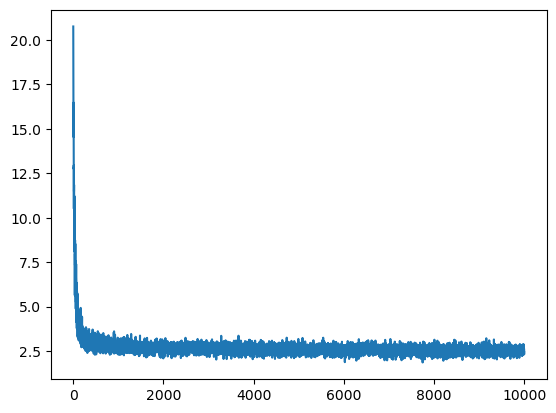

In [166]:
plt.plot(loss_log)

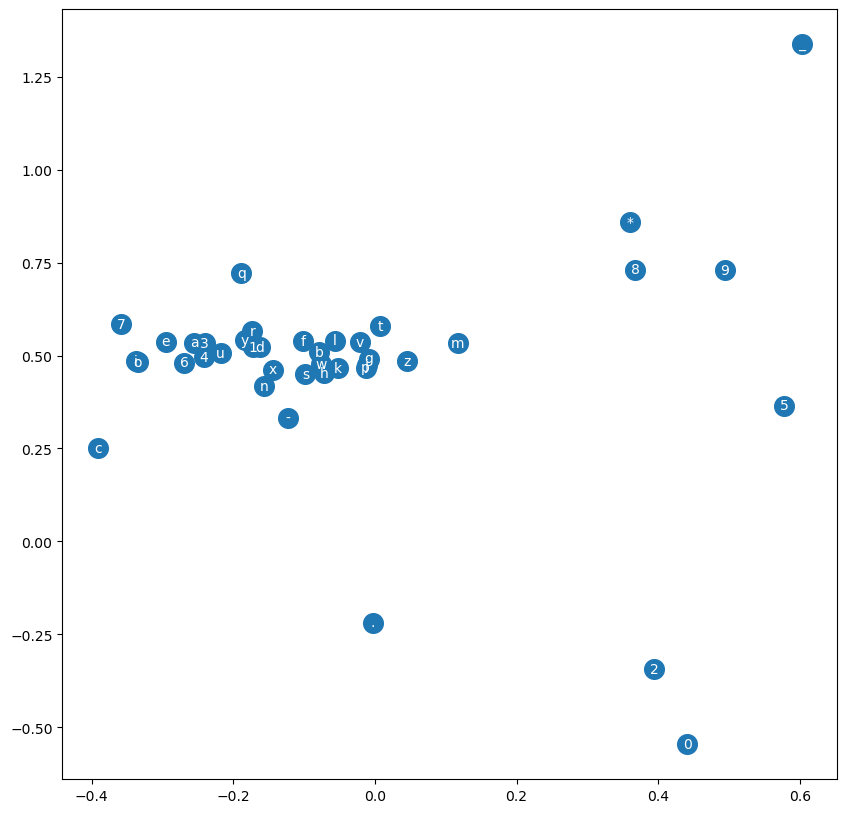

In [182]:
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")